# Implementing a Neural Network
In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [1]:
# A bit of setup
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

from cs231n.classifiers.neural_net import TwoLayerNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

We will use the class `TwoLayerNet` in the file `cs231n/classifiers/neural_net.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop your implementation.

In [2]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Open the file `cs231n/classifiers/neural_net.py` and look at the method `TwoLayerNet.loss`. This function is very similar to the loss functions you have written for the SVM and Softmax exercises: It takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [3]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720745909845e-08


# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularizaion loss.

In [4]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
0.01896541960606335


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [5]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    print(param_name)
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

b1
b1 max relative error: 2.738421e-09
W1
W1 max relative error: 4.090897e-09
b2
b2 max relative error: 4.447656e-11
W2
W2 max relative error: 3.440708e-09


# Train the network
To train the network we will use stochastic gradient descent (SGD), similar to the SVM and Softmax classifiers. Look at the function `TwoLayerNet.train` and fill in the missing sections to implement the training procedure. This should be very similar to the training procedure you used for the SVM and Softmax classifiers. You will also have to implement `TwoLayerNet.predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a two-layer network on toy data. You should achieve a training loss less than 0.2.

Final training loss:  0.017143643532923733


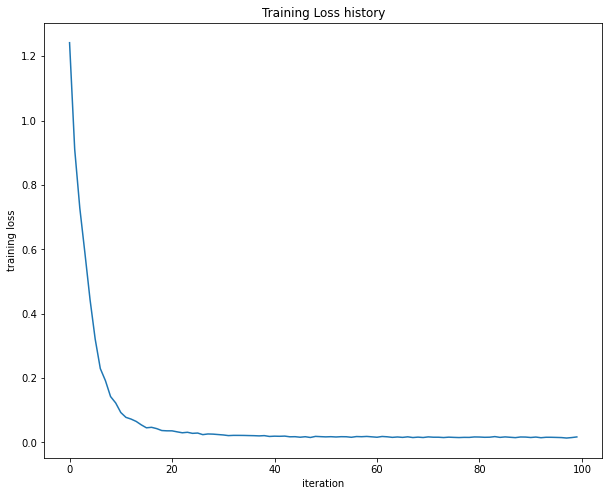

In [6]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Load the data
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [7]:
from cs231n.data_utils import load_CIFAR10
from sklearn.decomposition import PCA

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)
    
    #dimensionality reduction
    pca = PCA(n_components=0.9)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_val = pca.transform(X_val)
    X_test = pca.transform(X_test)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 99)
Train labels shape:  (49000,)
Validation data shape:  (1000, 99)
Validation labels shape:  (1000,)
Test data shape:  (1000, 99)
Test labels shape:  (1000,)


In [8]:
np.mean(X_train)

-3.332732811635827e-14

# Train a network
To train our network we will use SGD with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [147]:
input_size = X_train.shape[1]
hidden_size = 90
num_classes = 10
np.random.seed(7)
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=2000, batch_size=256,
            learning_rate=1.5821e-3, learning_rate_decay=0.95,
            reg=0.12, verbose=True)

# stats = net.train(X_train, y_train, X_val, y_val,
#             num_iters=1500, batch_size=1024,
#             learning_rate=2.3e-3, learning_rate_decay=0.95,
#             reg=1.8, verbose=True)

# Predict on the validation set
# Predict on the validation set
train_acc = (net.predict(X_train) == y_train).mean()
print('Training accuracy: ', train_acc)

val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

test_acc = (net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)


iteration 0 / 2000: loss 2.302571
iteration 100 / 2000: loss 1.752482
iteration 200 / 2000: loss 1.656304
iteration 300 / 2000: loss 1.618049
iteration 400 / 2000: loss 1.605927
iteration 500 / 2000: loss 1.552249
iteration 600 / 2000: loss 1.537486
iteration 700 / 2000: loss 1.541737
iteration 800 / 2000: loss 1.588125
iteration 900 / 2000: loss 1.456201
iteration 1000 / 2000: loss 1.507989
iteration 1100 / 2000: loss 1.478348
iteration 1200 / 2000: loss 1.477825
iteration 1300 / 2000: loss 1.484268
iteration 1400 / 2000: loss 1.286078
iteration 1500 / 2000: loss 1.406673
iteration 1600 / 2000: loss 1.480396
iteration 1700 / 2000: loss 1.338005
iteration 1800 / 2000: loss 1.456706
iteration 1900 / 2000: loss 1.377169
Training accuracy:  0.5356122448979592
Validation accuracy:  0.497
Test accuracy:  0.522


# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

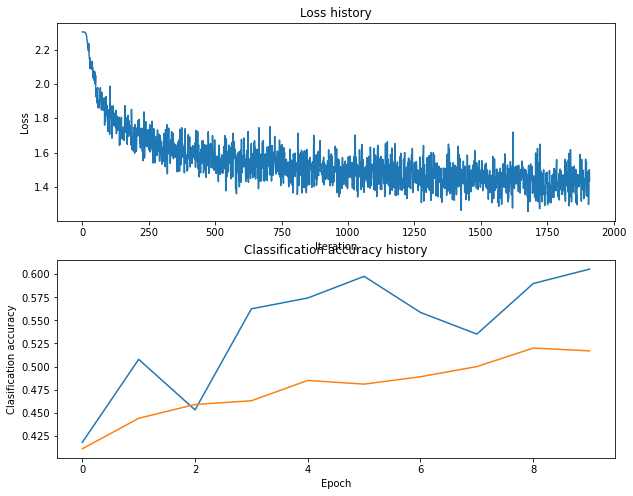

In [113]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

In [118]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    print(W1.shape)
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    print(W1.shape)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

(99, 50)


ValueError: cannot reshape array of size 4950 into shape (32,32,3,newaxis)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. For every 1% above 52% on the Test set we will award you with one extra bonus point. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [18]:
learning_rates = -7 * np.random.rand(35)
learning_rates = 10 ** learning_rates
regularization_strengths = 4 * np.random.rand(20)
regularization_strengths = 10 ** regularization_strengths
hidden_states = np.array([40,50,60])

In [24]:
results = {}
total_stats = {}
best_val = -1
best_net = None

input_size = 32 * 32 * 3
num_classes = 10


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
count = 0
for n_h in hidden_states:
    for lr in learning_rates:
        for reg in regularization_strengths:
            count += 1
            print(count)
            net = TwoLayerNet(input_size, n_h, num_classes)
            stats = net.train(X_train, y_train, X_val, y_val,
                              num_iters=100, batch_size=128,
                              learning_rate=lr, learning_rate_decay=0.95,
                              reg=reg, verbose=False)
            y_train_pred = net.predict(X_train)
            y_val_pred = net.predict(X_val)
            train_accuracy = np.mean(y_train_pred == y_train)
            val_accuracy = np.mean(y_val_pred == y_val)
            results[(n_h, lr, reg)] = (train_accuracy, val_accuracy)
            total_stats[(n_h, lr, reg)] = stats
            if val_accuracy > best_val:
                best_val = val_accuracy
                best_net = net
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for n_h, lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(n_h, lr, reg)]
    print('Nh %e lr %e reg %e train accuracy: %f val accuracy: %f' % (
                n_h, lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


D:\Deep Learning - Stanford\assignment1\cs231n\classifiers\neural_net.py:97: RuntimeWarning: overflow encountered in exp
  exp = np.exp(scores)
D:\Deep Learning - Stanford\assignment1\cs231n\classifiers\neural_net.py:98: RuntimeWarning: invalid value encountered in true_divide
  probs = exp / np.sum(exp, axis = 1, keepdims = True)
D:\Deep Learning - Stanford\assignment1\cs231n\classifiers\neural_net.py:100: RuntimeWarning: divide by zero encountered in log
  Li = - np.log(probs[range(N), y])


22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
29

1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071


Nh 6.000000e+01 lr 2.736387e-06 reg 4.289221e+03 train accuracy: 0.110449 val accuracy: 0.099000
Nh 6.000000e+01 lr 3.256036e-06 reg 3.929769e+00 train accuracy: 0.099408 val accuracy: 0.098000
Nh 6.000000e+01 lr 3.256036e-06 reg 5.788719e+00 train accuracy: 0.094837 val accuracy: 0.102000
Nh 6.000000e+01 lr 3.256036e-06 reg 6.697507e+00 train accuracy: 0.103531 val accuracy: 0.087000
Nh 6.000000e+01 lr 3.256036e-06 reg 1.004200e+01 train accuracy: 0.102980 val accuracy: 0.108000
Nh 6.000000e+01 lr 3.256036e-06 reg 1.925807e+01 train accuracy: 0.125143 val accuracy: 0.126000
Nh 6.000000e+01 lr 3.256036e-06 reg 1.950103e+01 train accuracy: 0.109449 val accuracy: 0.108000
Nh 6.000000e+01 lr 3.256036e-06 reg 2.346956e+01 train accuracy: 0.106061 val accuracy: 0.111000
Nh 6.000000e+01 lr 3.256036e-06 reg 2.723237e+01 train accuracy: 0.115102 val accuracy: 0.119000
Nh 6.000000e+01 lr 3.256036e-06 reg 4.042430e+01 train accuracy: 0.103551 val accuracy: 0.113000
Nh 6.000000e+01 lr 3.256036e-0

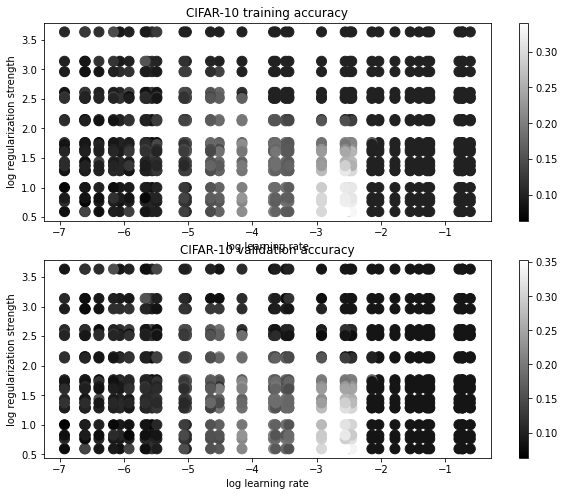

In [27]:
# Visualize the cross-validation results
nh = 60
import math
x_scatter = [math.log10(x[1]) for x in results if x[0] == nh]
y_scatter = [math.log10(x[2]) for x in results if x[0] == nh]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results if x[0] == nh]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results if x[0] == nh] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [35]:
np.arange(0,5,0.5)

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5])

In [76]:
learning_rates = np.arange(0.0015,0.0035,0.00012)
regularization_strengths = np.arange(0,4,0.1)
hidden_states = np.array([50,70,90])

In [78]:
results = {}
total_stats = {}
best_val = -1
best_net = None

input_size = X_train.shape[1]
num_classes = 10


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
count = 0
for n_h in hidden_states:
    for lr in learning_rates:
        for reg in regularization_strengths:
            count += 1
            print(count)
            net = TwoLayerNet(input_size, n_h, num_classes)
            stats = net.train(X_train, y_train, X_val, y_val,
                              num_iters=1000, batch_size=256,
                              learning_rate=lr, learning_rate_decay=0.95,
                              reg=reg, verbose=False)
            y_train_pred = net.predict(X_train)
            y_val_pred = net.predict(X_val)
            train_accuracy = np.mean(y_train_pred == y_train)
            val_accuracy = np.mean(y_val_pred == y_val)
            results[(n_h, lr, reg)] = (train_accuracy, val_accuracy)
            total_stats[(n_h, lr, reg)] = stats
            if val_accuracy > best_val:
                best_val = val_accuracy
                best_net = net
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for n_h, lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(n_h, lr, reg)]
    print('Nh %e lr %e reg %e train accuracy: %f val accuracy: %f' % (
                n_h, lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
Nh 5.000000e+01 lr 1.500000e-03 reg 0.000000e+00 train accuracy: 0.482184 val accuracy: 0.465000
Nh 

Nh 7.000000e+01 lr 1.980000e-03 reg 1.200000e+00 train accuracy: 0.480857 val accuracy: 0.470000
Nh 7.000000e+01 lr 1.980000e-03 reg 1.300000e+00 train accuracy: 0.464041 val accuracy: 0.477000
Nh 7.000000e+01 lr 1.980000e-03 reg 1.400000e+00 train accuracy: 0.454490 val accuracy: 0.436000
Nh 7.000000e+01 lr 1.980000e-03 reg 1.500000e+00 train accuracy: 0.477061 val accuracy: 0.478000
Nh 7.000000e+01 lr 1.980000e-03 reg 1.600000e+00 train accuracy: 0.471571 val accuracy: 0.464000
Nh 7.000000e+01 lr 1.980000e-03 reg 1.700000e+00 train accuracy: 0.447633 val accuracy: 0.424000
Nh 7.000000e+01 lr 1.980000e-03 reg 1.800000e+00 train accuracy: 0.470163 val accuracy: 0.460000
Nh 7.000000e+01 lr 1.980000e-03 reg 1.900000e+00 train accuracy: 0.462796 val accuracy: 0.448000
Nh 7.000000e+01 lr 1.980000e-03 reg 2.000000e+00 train accuracy: 0.450490 val accuracy: 0.469000
Nh 7.000000e+01 lr 1.980000e-03 reg 2.100000e+00 train accuracy: 0.466490 val accuracy: 0.474000
Nh 7.000000e+01 lr 1.980000e-0

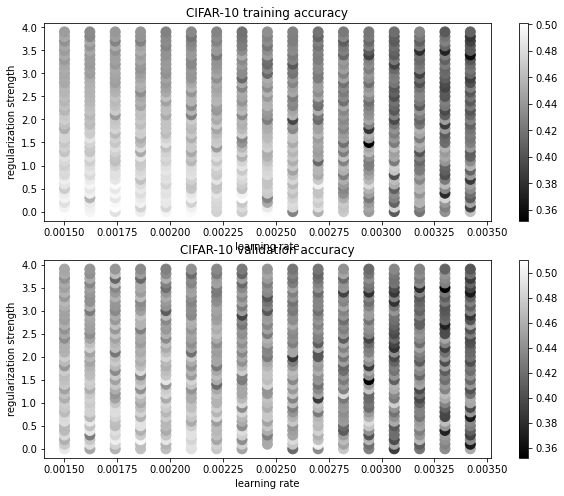

In [108]:
# Visualize the cross-validation results
nh = 90
x_scatter = [x[1] for x in results if x[0] == nh]
y_scatter = [x[2] for x in results if x[0] == nh]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results if x[0] == nh]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('learning rate')
plt.ylabel('regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results if x[0] == nh] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('learning rate')
plt.ylabel('regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

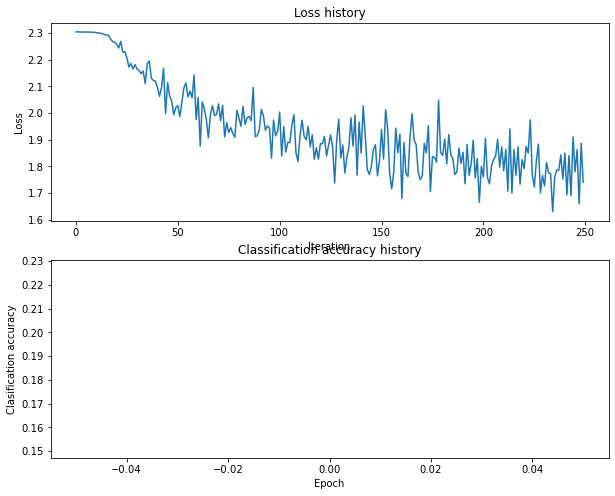

In [56]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(total_stats[(60,0.0015,2.5)]['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(total_stats[(60,0.0015,2.5)]['train_acc_history'], label='train')
plt.plot(total_stats[(60,0.0015,2.5)]['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

In [ ]:
best_net = None # store the best model into this 

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
pass
#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################

In [ ]:
# visualize the weights of the best network
show_net_weights(best_net)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

**We will give you extra bonus point for every 1% of accuracy above 52%.**

In [158]:
test_acc = (net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.487
